# **Segmentación de Clientes Mediante Clustering en Campañas de Mailing: Un Enfoque de Data Science para el Marketing**

## Introducción

En este trabajo, vamos a comenzar con un **EDA (Exploratory Data Analysis)** para analizar el **dataset** que fue proporcionado. El objetivo de esta fase es verificar que las **variables** estén correctas, identificar posibles **inconsistencias** en los datos y detectar la presencia de **outliers**. Posteriormente, aplicaremos **algoritmos de aprendizaje no supervisados** para segmentar a los clientes de una campaña de **mailing**. La idea es clasificar a los usuarios según su comportamiento con los correos electrónicos (aperturas, clics, etc.) y detectar patrones útiles para el equipo de **marketing**.

Es importante aclarar que el **dataset** fue proporcionado sin ninguna referencia sobre el significado de las columnas, los valores que pueden tomar y cómo deben ser interpretadas. Por lo tanto, parte del análisis inicial se enfocará en inferir el significado de cada variable y su validez.

Durante el análisis, se crearán **nuevas variables** que enriquecerán el proceso de **clusterización**. Utilizando técnicas de **clustering**, buscaremos dividir a los usuarios en grupos (clusters) con comportamientos similares, sin necesidad de tener hipótesis previas.

Al final, se analizarán los grupos generados, identificando características que puedan ser útiles desde una perspectiva de marketing. Esto permitirá hacer recomendaciones específicas para mejorar las futuras campañas de mailing, basadas en el comportamiento de cada segmento de clientes.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
url = "https://raw.githubusercontent.com/Ezegarcia07/Email-Engagement-Clustering/refs/heads/main/clustering_mailing%20-%20Sheet1.csv"
df = pd.read_csv(url)
df.sample(5)

,Id,send,bounce,open,click,Total,Comprador,hour,day_of_week
186088,1020736,1,0,0,0,1,1,20,4
107732,2035325,1,1,0,0,2,0,18,2
160702,1481767,5,0,0,0,5,0,"20,6","1,4"
48052,1800552,1,0,3,0,4,0,"15,75","3,75"
195813,49673,19,0,4,4,27,1,"19,11111111","2,555555556"


In [4]:
df.head()

,Id,send,bounce,open,click,Total,Comprador,hour,day_of_week
0,2044163,4,0,0,0,4,0,17,"3,5"
1,633731,1,0,0,0,1,0,21,4
2,1537126,4,0,0,0,4,0,17,"3,5"
3,1960135,3,0,0,0,3,0,"15,33333333","3,333333333"
4,1004992,8,0,1,0,10,1,"18,22222222",2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212292 entries, 0 to 212291
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Id           212292 non-null  int64 
 1   send         212292 non-null  int64 
 2   bounce       212292 non-null  int64 
 3   open         212292 non-null  int64 
 4   click        212292 non-null  int64 
 5   Total        212292 non-null  int64 
 6   Comprador    212292 non-null  int64 
 7   hour         212292 non-null  object
 8   day_of_week  212292 non-null  object
dtypes: int64(7), object(2)
memory usage: 14.6+ MB


In [6]:
df.describe()

,Id,send,bounce,open,click,Total,Comprador
count,2.122920e+05,212292.000000,212292.000000,212292.000000,212292.000000,212292.000000,212292.000000
mean,1.062074e+06,3.757801,0.264273,0.483819,0.072108,4.680077,0.616542
std,6.119871e+05,3.838834,0.665326,1.564734,0.607759,4.964009,0.486229
min,0.000000e+00,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,5.336052e+05,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000
50%,1.062491e+06,2.000000,0.000000,0.000000,0.000000,3.000000,1.000000
75%,1.592284e+06,5.000000,0.000000,0.000000,0.000000,6.000000,1.000000
max,2.122907e+06,167.000000,55.000000,174.000000,106.000000,390.000000,1.000000


In [7]:
df.isna().sum()

,0
Id,0
send,0
bounce,0
open,0
click,0
Total,0
Comprador,0
hour,0
day_of_week,0


#### Primera Conclusión

Una primera conclusión que se desprende de estos primeros análisis es que, al aplicar el comando `head()`, se observa que en la fila 4 hay una **inconsistencia**. El valor en la columna **Total** es igual a 10, pero no existe una combinación posible con las otras variables (exceptuando la columna **Comprador**, que es binaria, y las columnas **hour** y **day_of_week**).

Es necesario investigar si este problema se repite en otras filas del dataset, por lo que realizaremos un análisis más detallado para ver cuántas filas presentan este mismo tipo de inconsistencia.


In [8]:
check_total = df['send'] + df['open'] + df['click'] + df["bounce"] #+ df["Comprador"]
is_total_correct = df['Total'] == check_total

summary = pd.DataFrame({
    'Total': df['Total'],
    'Computed_Total': check_total,
    'Is_Correct': is_total_correct
})

print(summary['Is_Correct'].value_counts())
summary.head()


Is_Correct
True     197009
False     15283
Name: count, dtype: int64


,Total,Computed_Total,Is_Correct
0,4,4,True
1,1,1,True
2,4,4,True
3,3,3,True
4,10,9,False


#### Tratamiento de la Columna Total

Se observa claramente que hay más de **quince mil registros** que no tienen la suma correcta de las columnas **send**, **open**, **click** y **bounce**. Por lo tanto, será necesario realizar un tratamiento en la columna **Total**.

La estrategia consistirá en **eliminar** la columna **Total** y, en su lugar, crear una nueva variable llamada **real_total**, que representará la suma de las columnas **send**, **bounce**, **open** y **click**. Estas columnas juntas reflejan las interacciones totales que tenemos con cada cliente.


In [9]:
df['real_total'] = df['send'] + df['open'] + df['click'] + df["bounce"]

df = df.drop(columns=['Total'])

cols = df.columns.tolist()
cols.insert(5, cols.pop(cols.index('real_total')))

df = df[cols]

df.head()

,Id,send,bounce,open,click,real_total,Comprador,hour,day_of_week
0,2044163,4,0,0,0,4,0,17,"3,5"
1,633731,1,0,0,0,1,0,21,4
2,1537126,4,0,0,0,4,0,17,"3,5"
3,1960135,3,0,0,0,3,0,"15,33333333","3,333333333"
4,1004992,8,0,1,0,9,1,"18,22222222",2


#### Análisis de Inconsistencias en `day_of_week` y `hour`

La segunda conclusión que podemos sacar de estos primeros análisis es la aparición del valor **3.333333** en la columna **day_of_week**, lo cual claramente representa una **inconsistencia**. Este valor no tiene sentido y, por lo tanto, se **eliminará** (dropear) dicha fila.

En cuanto a la columna **hour**, podría tener sentido si representara la hora exacta en la que se envió un solo correo electrónico. Sin embargo, hemos observado que hay clientes al que se le enviaron más de un correo. Por ejemplo, el **ID 1960135** recibió 3 correos, a las **15,3333 hs**, y en el **día de la semana 3.3333333**.

Este comportamiento genera dudas, ya que no es claro cómo se han representado estos datos. Es posible que esas variables reflejen un **promedio** de las horas y días. Por ejemplo, el ID 1960135 pudo haber recibido correos los días 2, 3 y 5, y el promedio de esos días podría haber dado como resultado **3.3333333** en la columna **day_of_week**.

Dado que estas inconsistencias no proporcionan información útil, se **eliminarán** (dropearán) ambas columnas: **day_of_week** y **hour**.


In [10]:
drop_columns = ['hour', 'day_of_week']
df.drop(drop_columns, axis=1, inplace=True)
df.head(10)

,Id,send,bounce,open,click,real_total,Comprador
0,2044163,4,0,0,0,4,0
1,633731,1,0,0,0,1,0
2,1537126,4,0,0,0,4,0
3,1960135,3,0,0,0,3,0
4,1004992,8,0,1,0,9,1
5,1598931,2,0,0,0,2,1
6,2027234,1,1,0,0,2,0
7,34136,5,0,5,2,12,1
8,1440219,2,0,0,0,2,1
9,41994,7,0,7,2,16,0


#### Análisis de la Variable `Comprador`

Ahora vamos a analizar la variable **Comprador**. Esta variable nos indica si un cliente realizó una compra o no, tomando valores binarios: **1** significa que el cliente compró, y **0** que no compró.

Una posible duda que debemos verificar si existe es que algún cliente que tenga el valor **1** en la variable **Comprador** pero que no haya interactuado con ningún correo electrónico. Es decir, nos preguntamos si hay algún caso en el que un cliente haya realizado una compra sin haber abierto o clickeado ningún correo. Realicemos una revisión de estos casos.


In [11]:
no_interaction_buyers = df.query("Comprador == 1 and open == 0 and click == 0")
print(no_interaction_buyers.shape)
no_interaction_buyers.head()

(96110, 7)


,Id,send,bounce,open,click,real_total,Comprador
5,1598931,2,0,0,0,2,1
8,1440219,2,0,0,0,2,1
12,354737,2,0,0,0,2,1
18,928624,7,0,0,0,7,1
20,352644,18,0,0,0,18,1


#### 🔍 Análisis de Compradores sin Interacción con Emails

Efectivamente, observamos que en **más de 96,000 casos** hay clientes que **han comprado** pero **no han interactuado** con ningún email enviado.  

##### ❓ ¿Cómo puede ser esto posible?
Dado que el dataset fue proporcionado **sin referencias claras** sobre su creación y significado de las variables, podemos **establecer una hipótesis**:  
📌 **Un cliente pudo haber realizado una compra en el sitio web oficial de la marca, sin necesidad de interactuar con los emails**.  

##### ✅ Conclusión:
El hecho de que estos clientes compren **sin abrir ni hacer clic en los emails** indica que su decisión de compra **no está influenciada directamente por las campañas de email marketing**, sino que probablemente provenga de **otros canales** como:  
- **Tráfico directo a la web**  
- **Publicidad en otros medios**  
- **Recomendaciones**  



### Transformación del DataFrame para la Clusterización

En esta etapa, vamos a crear tres variables de interés que nos ayudarán a obtener información sobre las interacciones de los clientes con los correos electrónicos.

##### 📌 Descripción de las Variables Creadas

- **`open_rate`** = `open / (send - bounce)`  
  - Representa la **tasa de apertura** de los emails considerando solo los correos **entregados** (descontando los que rebotaron).  
  - Indica el **porcentaje** de correos que fueron abiertos por el usuario.

- **`CTR` (Click-Through Rate)** = `click / open`  
  - Mide la **efectividad** del email en generar clics entre los usuarios que lo abrieron.  
  - Un valor alto sugiere que el contenido del correo es **atractivo** y genera interacción.

- **`interaction_rate`** = `(open + click) / (send + open + click)`  
  - Representa el **nivel general de interacción** con los correos.  
  - Combina aperturas y clics en relación con el total de envíos y acciones realizadas.

Estas variables nos permiten **segmentar usuarios** según su nivel de interacción con los emails, ayudando a optimizar las estrategias de marketing. 🚀



In [12]:
df['open_rate'] = df['open'] / (df['send'] - df['bounce'])  # Tasa de apertura ajustada
df['CTR'] = df['click'] / df['open']  # Click-through rate
df['interaction_rate'] = (df['open'] + df['click']) / (df['send'] + df['open'] + df['click'])  # Interacción total

In [13]:
df.sample(10)

,Id,send,bounce,open,click,real_total,Comprador,open_rate,CTR,interaction_rate
195597,1331754,1,1,0,0,2,0,NaN,NaN,0.0
61410,1347443,1,1,0,0,2,0,NaN,NaN,0.0
116685,371025,6,0,0,0,6,1,0.00,NaN,0.0
139,593630,4,0,0,0,4,1,0.00,NaN,0.0
160044,1730026,4,0,1,0,5,1,0.25,0.0,0.2
134233,1773118,2,0,0,0,2,1,0.00,NaN,0.0
43277,563462,2,0,0,0,2,1,0.00,NaN,0.0
92706,144140,1,1,0,0,2,0,NaN,NaN,0.0
132880,243064,7,0,0,0,7,1,0.00,NaN,0.0
78200,2012159,1,1,0,0,2,0,NaN,NaN,0.0


In [14]:
df.isna().sum()

,0
Id,0
send,0
bounce,0
open,0
click,0
real_total,0
Comprador,0
open_rate,39297
CTR,166102
interaction_rate,0


#### Manejo de Datos Nulos

En el análisis, hemos encontrado que existen **valores nulos** en algunas de las variables, debido a que, en ocasiones, el número de **send** y **bounce** es el mismo, lo que genera una **división por cero**. Además, cuando no hay correos abiertos, el **CTR** (Click-Through Rate) también resulta en un valor nulo.

Para solucionar esto, vamos a **rellenar esos valores nulos con cero**. De esta manera, evitamos que los cálculos fallidos afecten el análisis y aseguramos que todas las variables tengan valores numéricos consistentes.

El proceso de reemplazo de nulos por cero se aplicará a las columnas afectadas, asegurando que las métricas de interacción puedan ser calculadas correctamente.


In [15]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [16]:
df.isna().sum()

,0
Id,0
send,0
bounce,0
open,0
click,0
real_total,0
Comprador,0
open_rate,0
CTR,0
interaction_rate,0


In [17]:
df.columns

Index(['Id', 'send', 'bounce', 'open', 'click', 'real_total', 'Comprador',
       'open_rate', 'CTR', 'interaction_rate'],
      dtype='object')

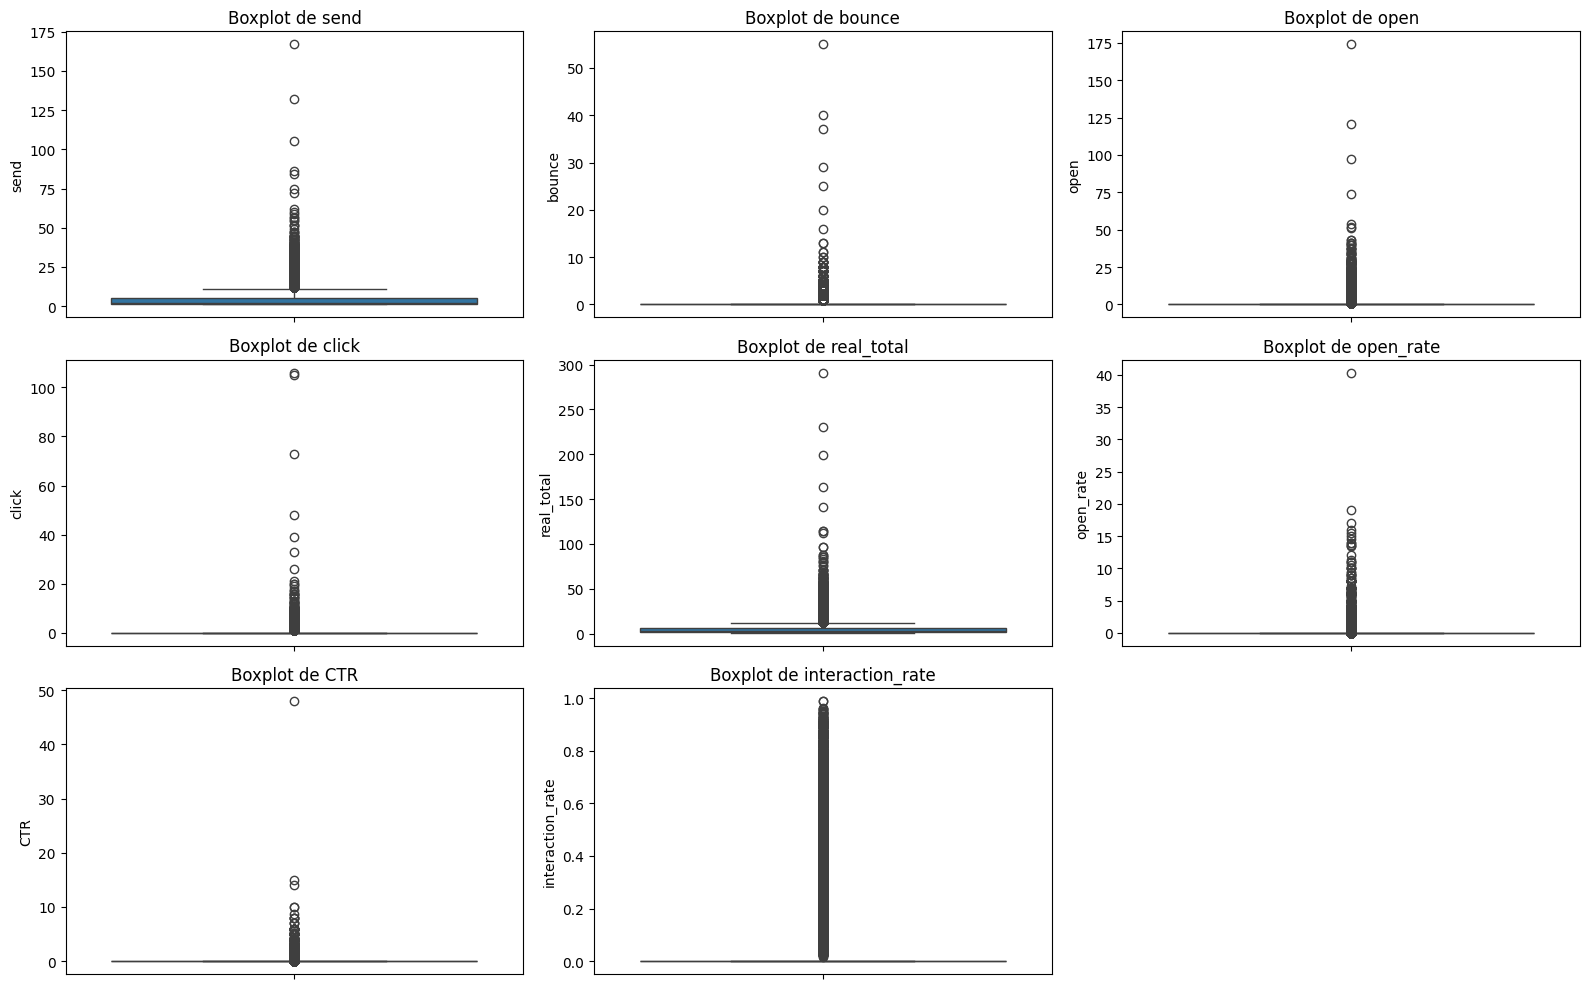

In [18]:
plt.figure(figsize=(16, 10))

plt.subplot(3, 3, 1)
sns.boxplot(y=df['send'])
plt.title('Boxplot de send')

plt.subplot(3, 3, 2)
sns.boxplot(y=df['bounce'])
plt.title('Boxplot de bounce')

plt.subplot(3, 3, 3)
sns.boxplot(y=df['open'])
plt.title('Boxplot de open')

plt.subplot(3, 3, 4)
sns.boxplot(y=df['click'])
plt.title('Boxplot de click')

plt.subplot(3, 3, 5)
sns.boxplot(y=df['real_total'])
plt.title('Boxplot de real_total')

plt.subplot(3, 3, 6)
sns.boxplot(y=df['open_rate'])
plt.title('Boxplot de open_rate')

plt.subplot(3, 3, 7)
sns.boxplot(y=df['CTR'])
plt.title('Boxplot de CTR')

plt.subplot(3, 3, 8)
sns.boxplot(y=df['interaction_rate'])
plt.title('Boxplot de interaction_rate')

plt.tight_layout()
plt.show()


#### Análisis de Outliers

A partir de los **boxplots** generados, podemos observar que todas las variables presentan **outliers**. Sin embargo, lo que más nos llama la atención son las variables que creamos, como **`open_rate`** y **`CTR`**, que en teoría deberían tener valores máximos de **1**, pero no es así.

Este comportamiento se debe a que, en ocasiones, los valores de **open** o **click** superan el número de **emails entregados**. Esto sugiere que el **dataset** podría estar contando múltiples interacciones con el mismo correo. Es decir, un cliente podría haber **abierto el correo más de una vez** o **hecho clic varias veces** en el mismo correo.

Dado que el **dataset** no especifica si se trata de múltiples interacciones, abordaremos este enfoque, ya que debemos encontrar una manera de manejar estos casos y entender las interacciones de los clientes con los emails.


#### Estrategia para Manejar los Outliers  

Para abordar este problema, tomaremos **dos enfoques diferentes**:  

1. **Mantener los outliers** y aplicar **técnicas de estandarización** para reducir su impacto en el análisis. De esta manera, evitamos eliminar información y simplemente ajustamos su influencia en el modelo.  

2. **Limitar los valores de las variables creadas** (`open_rate`, `CTR`, `interaction_rate`) para que no superen **1**. Esto se basa en la idea de que un valor de **1** representa el nivel máximo de interacción, sin contar **múltiples acciones** (por ejemplo, abrir un mismo email varias veces o hacer más clics de los emails disponibles podria llevarse al valor 1 por el hecho que se sabe que interactuo).  

Ambos métodos nos permitirán evaluar cuál es la mejor manera de tratar estas inconsistencias y qué impacto tienen en la segmentación final de los clientes.  


#### Selección de Variables para la Clusterización  

Para la **clusterización**, utilizaremos únicamente **dos variables** creadas:  

- **`open_rate`**  
- **`CTR` (Click-Through Rate)**  

Estas dos variables nos permitirán realizar una **buena segmentación** de los clientes en función de sus interacciones con los emails. Nos interesa especialmente analizar:  

✅ **Si abrieron el email** (`open_rate`).  
✅ **Si hicieron clic en el contenido** (`CTR`), lo que indica que encontraron atractivo el cuerpo del email.  

Al enfocarnos en estas métricas, podremos clasificar a los clientes según su nivel de interacción y definir estrategias de marketing más efectivas para cada grupo.  


#### 🔹 Primer Enfoque: Mantener los Outliers  

En este primer enfoque, decidimos **no eliminar los outliers**, sino mantenerlos tal como están en el dataset original.  

Dado que los valores extremos pueden influir en la clusterización, aplicaremos **técnicas de escalado** para reducir su impacto y asegurarnos de que no dominen el proceso de segmentación.  

➡️ **Estrategia:**  
1. **No eliminar ni modificar los valores atípicos.**  
2. **Escalar** las variables `open_rate` y `CTR` utilizando **MinMaxScaler**, que transformará los valores al rango `[0,1]`, manteniendo la distribución original pero reduciendo la influencia de los valores extremos.  
3. Proceder con la clusterización utilizando los datos transformados.  

Este método nos permitirá evaluar cómo afectan los **outliers** a la segmentación y si proporcionan información relevante o simplemente generan ruido.  


In [19]:
from sklearn.preprocessing import MinMaxScaler

# Inicializar el MinMaxScaler
scaler = MinMaxScaler()

# Normalizar las columnas de interés: 'open_rate', 'CTR'
df_1 = df.copy()
df_1[['open_rate', 'CTR']] = scaler.fit_transform(df_1[['open_rate', 'CTR']])

# Verificar las estadísticas después de la normalización
df_1[['open_rate', 'CTR']].describe()


,open_rate,CTR
count,212292.000000,212292.000000
mean,0.003744,0.000703
std,0.011275,0.005507
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


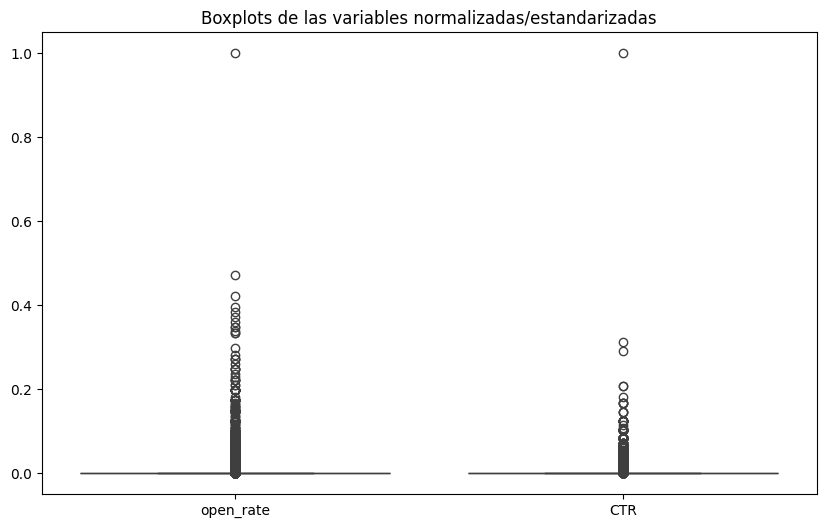

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Mostrar boxplot solo para 'open_rate' y 'CTR'
sns.boxplot(data=df_1[['open_rate', 'CTR']])
plt.title("Boxplots de las variables normalizadas/estandarizadas")
plt.show()


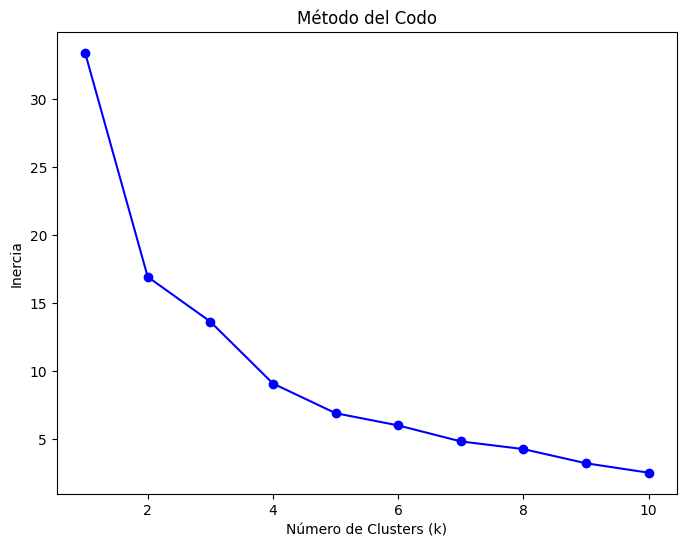

In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Valores de k que vamos a probar
k_values = range(1, 11)
inertia = []

# Calcular la inercia para cada valor de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_1[['open_rate', 'CTR']])
    inertia.append(kmeans.inertia_)

# Graficar el codo
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o', color='b')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.show()



In [22]:
kmeans = KMeans(n_clusters=4, random_state=42)

clusters = kmeans.fit_predict(df_1[['open_rate', 'CTR']])

df_1['kmeans_cluster_1'] = clusters


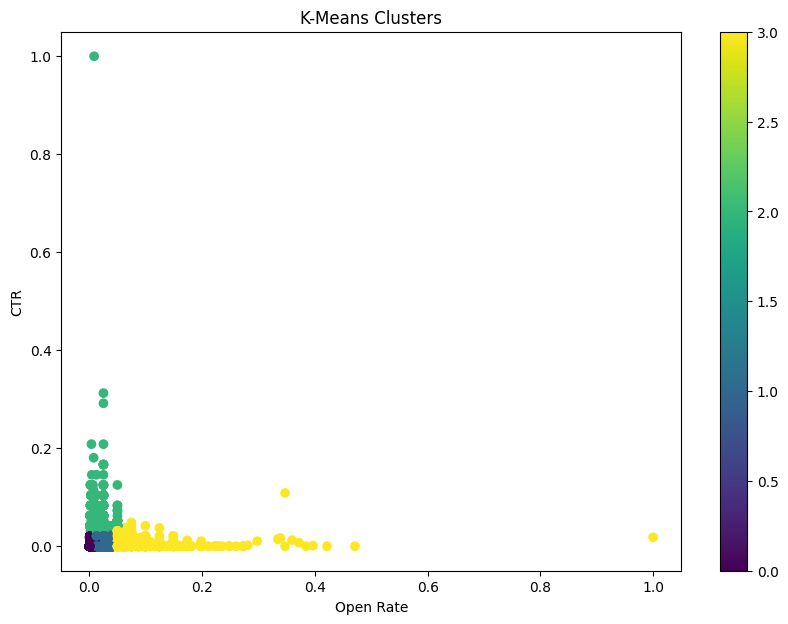

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(df_1['open_rate'],
            df_1['CTR'],
            c=df_1['kmeans_cluster_1'],
            cmap='viridis')
plt.xlabel('Open Rate')
plt.ylabel('CTR')
plt.title('K-Means Clusters')
plt.colorbar()
plt.show()

#### 📊 Análisis del Impacto de los Outliers en la Clusterización  

A partir del gráfico generado, observamos que los **outliers** juegan un papel importante en la clusterización con **K-Means**.  

##### 🔍 Principales Problemas Detectados:  
1. **Pérdida de información**:  
   - Al aplicar **MinMaxScaler**, la mayoría de los datos quedan **concentrados cerca de 0**, lo que reduce la variabilidad y la capacidad del modelo para diferenciar segmentos significativos.  

2. **Clusters poco interpretables**:  
   - Los grupos generados por **K-Means** **no tienen una diferenciación clara** desde el punto de vista conceptual.  
   - No podemos identificar fácilmente qué clientes son los que **más abren** y **más cliquean** los emails, ya que la **esquina superior derecha del gráfico está vacía**.  
   - Esto sugiere que los **outliers están distorsionando la distribución**, afectando negativamente la segmentación.  



In [24]:
#from sklearn.cluster import DBSCAN
#import seaborn as sns
#import matplotlib.pyplot as plt

#dbscan = DBSCAN(eps=0.5, min_samples=15)
#df_1['dbscan_cluster'] = dbscan.fit_predict(df_1[['open_rate', 'CTR']])

#sns.scatterplot(x='open_rate', y='CTR', hue='dbscan_cluster', data=df_1, palette='viridis')
#plt.title("Clusters obtenidos con DBSCAN")
#plt.show()

pd: se trato de aplicar DBSCAN pero el conjunto de datos es tan grande que hace que el costo computacional sea enorme a tal punto que crashea.  

Una primera alternativa a esto es hacer un sample del df original con menos datos y aplicar el algoritmo. Veamos que nos da.

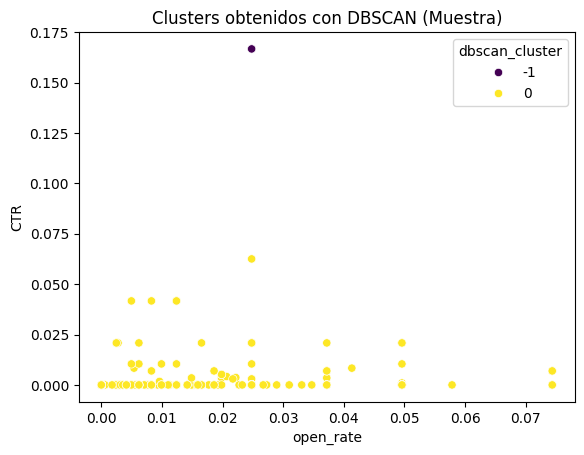

In [25]:
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

df_sample = df_1.sample(n=1000, random_state=42)

dbscan = DBSCAN(eps=0.1, min_samples=5)
df_sample['dbscan_cluster'] = dbscan.fit_predict(df_sample[['open_rate', 'CTR']])

sns.scatterplot(x='open_rate', y='CTR', hue='dbscan_cluster', data=df_sample, palette='viridis')
plt.title("Clusters obtenidos con DBSCAN (Muestra)")
plt.show()


#### ❌ Conclusión: Este Enfoque No Funciona  

La mayoría de los datos se concentran **alrededor de 0**, lo que queda aún más claro al tomar una muestra, ya que esta es más propensa a contener valores cercanos a 0.  

🔴 **Conclusión:** Este enfoque **no es útil**, ya que la información queda distorsionada y los clusters generados no representan patrones claros de interacción.  


#### 🔄 Alternativa: Uso de HDBSCAN  

🔹 **¿Por qué HDBSCAN?**  
- Maneja mejor el **costo computacional** en comparación con DBSCAN.  
- Funciona de manera **similar a DBSCAN**, pero ajusta automáticamente los parámetros para encontrar una segmentación más estable.  
- Permite **identificar ruido y outliers**, lo que puede ayudarnos a mejorar la clusterización.  

Vamos a probar este enfoque y analizar si obtenemos mejores resultados en la segmentación de clientes. 🚀  


In [26]:
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt

hdb = hdbscan.HDBSCAN(min_samples=15, cluster_selection_epsilon=0.5)

df_1['hdbscan_cluster_1'] = hdb.fit_predict(df_1[['open_rate', 'CTR']])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


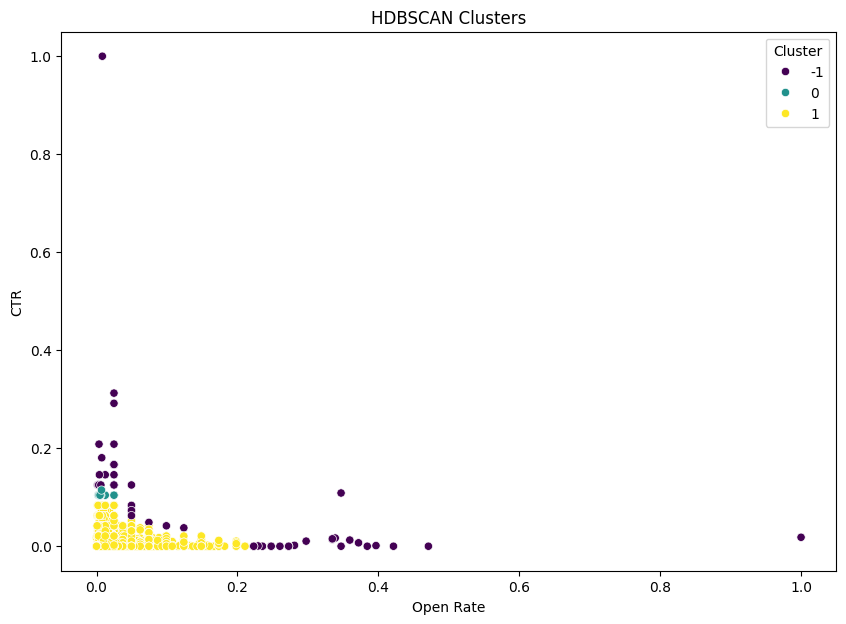

In [27]:
#import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))

sns.scatterplot(x='open_rate',
                y='CTR',
                hue='hdbscan_cluster_1',
                data=df_1,
                palette='viridis')

plt.title("HDBSCAN Clusters")
plt.xlabel('Open Rate')
plt.ylabel('CTR')
plt.legend(title='Cluster')
plt.show()

#### ❌ Conclusión: HDBSCAN Tampoco Funciona Bien  

Los gráficos generados **no aportan mucha información útil**, principalmente debido a la presencia de **outliers**.  

🔍 **Observaciones:**  
- **HDBSCAN detecta outliers**, pero los clusters restantes **no son claros** ni aportan una segmentación significativa.  
- El resultado es similar a lo que vimos con **K-Means**, sin una diferenciación conceptual útil para el análisis.  

📌 **Conclusión:** Mantener los outliers parece no ser la mejor opción. Pasemos ahora al **segundo enfoque**, donde trataremos los outliers antes de la clusterización. 🚀  


#### 🔹 Segundo Enfoque: Limitar los Valores Mayores a 1  

Dado que mantener los outliers **no nos dio buenos resultados**, probaremos una nueva estrategia:  

✅ **Si una variable tiene un valor mayor a 1, lo reemplazamos por 1.**  

📌 **Justificación:**  
- Esto representa el **máximo nivel de interacción posible**, sin contar múltiples acciones del mismo usuario (abrir el mismo email varias veces o hacer múltiples clics en un solo correo).  
- Nos aseguramos de que la escala de los datos sea más representativa y no distorsione la clusterización.  

Veamos si esta estrategia mejora la segmentación de los clientes. 🚀  


In [28]:
df_2 = df.copy()
df_2[['open_rate', 'CTR']] = df_2[['open_rate', 'CTR']].clip(upper=1)

print(df_2[['open_rate', 'CTR']].describe())


           open_rate            CTR
count  212292.000000  212292.000000
mean        0.122080       0.024291
std         0.285255       0.141583
min         0.000000       0.000000
25%         0.000000       0.000000
50%         0.000000       0.000000
75%         0.000000       0.000000
max         1.000000       1.000000


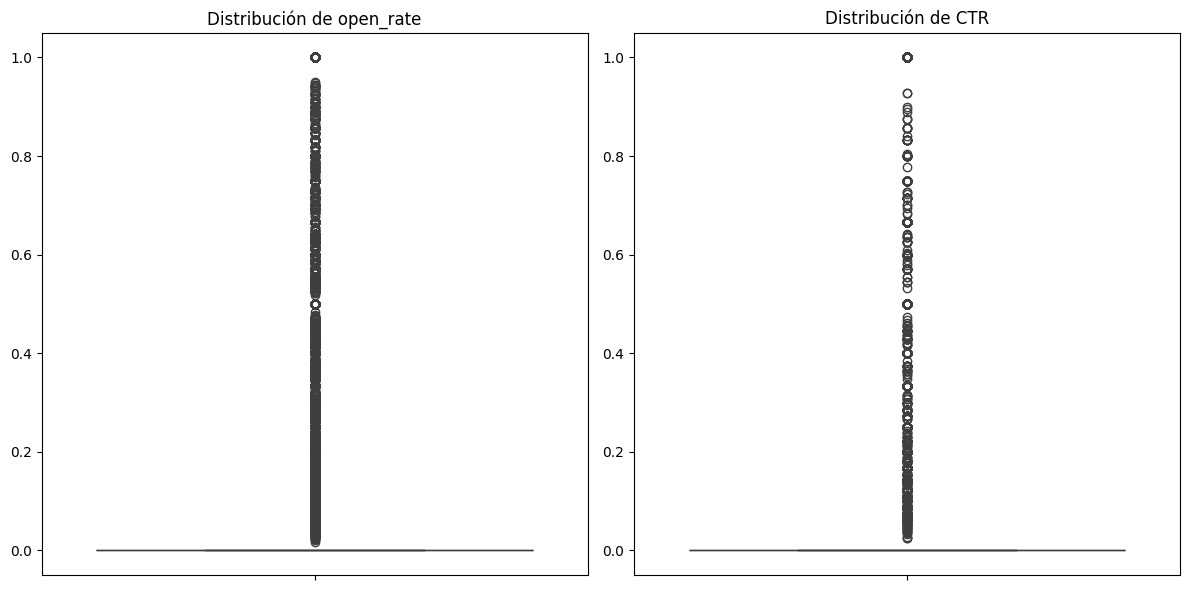

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

for i, col in enumerate(['open_rate', 'CTR'], 1):
    plt.subplot(1, 2, i)  # 1 fila, 2 columnas, posición i
    sns.boxplot(y=df_2[col])
    plt.title(f'Distribución de {col}')
    plt.ylabel('')

plt.tight_layout()
plt.show()

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_2[['open_rate', 'CTR']] = scaler.fit_transform(df_2[['open_rate', 'CTR']])

print(df_2[['open_rate', 'CTR']].describe())


           open_rate            CTR
count  212292.000000  212292.000000
mean        0.122080       0.024291
std         0.285255       0.141583
min         0.000000       0.000000
25%         0.000000       0.000000
50%         0.000000       0.000000
75%         0.000000       0.000000
max         1.000000       1.000000


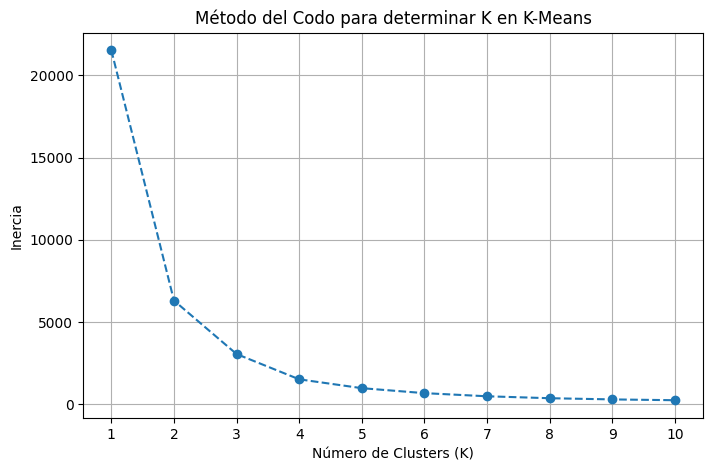

In [31]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

K_range = range(1, 11)
inertia_values = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_2[['open_rate', 'CTR']])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia_values, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar K en K-Means')
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [32]:
best_k = 4

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_2['kmeans_cluster'] = kmeans.fit_predict(df_2[['open_rate', 'CTR']])


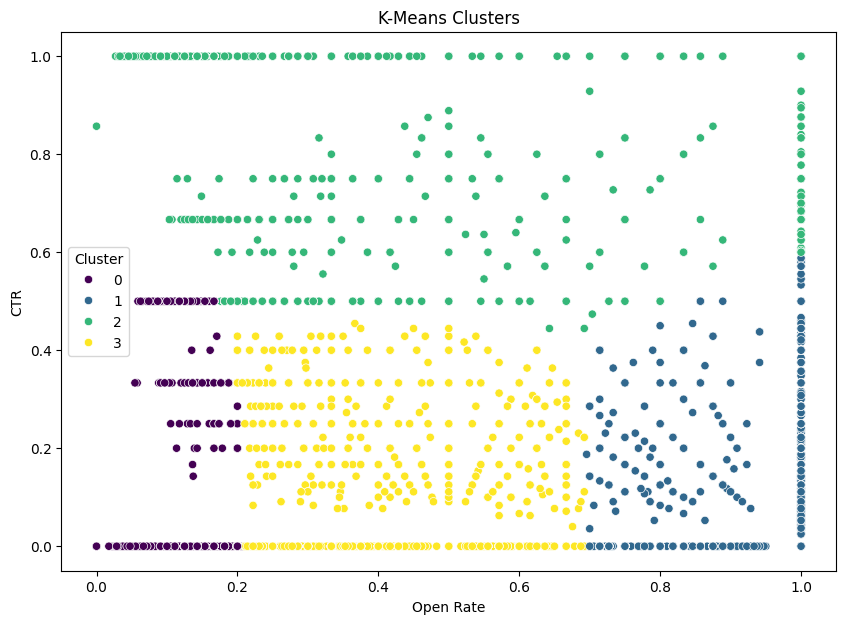

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))

sns.scatterplot(x='open_rate',
                y='CTR',
                hue='kmeans_cluster',
                data=df_2,
                palette='viridis')

plt.title("K-Means Clusters")
plt.xlabel('Open Rate')
plt.ylabel('CTR')
plt.legend(title='Cluster')
plt.show()

## ✅ Resultados del Gráfico de K-Means  

Este gráfico tiene **mucho más sentido**. Ahora los clusters están claramente diferenciados, lo que nos permite sacar algunas conclusiones iniciales desde una perspectiva de **marketing**:

- **Púrpura**: Clientes **inactivos o fríos** que interactúan poco o nada con los emails.  
- **Amarillo**: Grupo con un **rate medio de apertura**, pero con **pocos clics**.  
- **Azul**: Grupo que **abre muchos emails**, pero no hace muchos clics o incluso ninguno.  
- **Verde**: Clientes que **clickean mucho** cuando abren los emails, mostrando una alta interacción.  

📊 **Conclusión preliminar**: Ahora tenemos grupos de clientes que podemos abordar de manera diferente en nuestras campañas de marketing.  

Próximamente, aplicaremos **HDBSCAN** para ver si obtenemos resultados similares y compararemos este enfoque con el **primer enfoque**.   


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


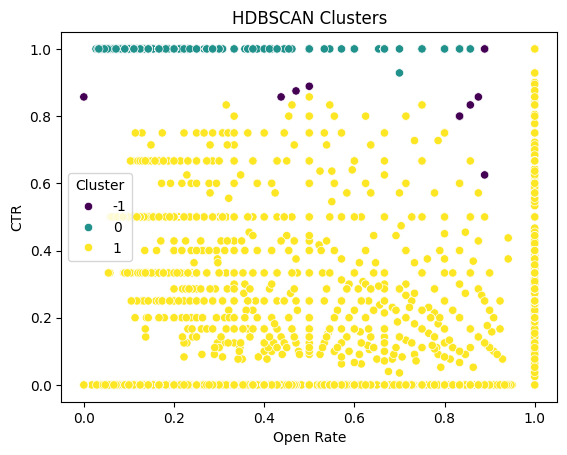

In [34]:
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt

hdb = hdbscan.HDBSCAN(min_samples=15, cluster_selection_epsilon=0.5)

df_2['hdbscan_cluster'] = hdb.fit_predict(df_2[['open_rate', 'CTR']])

sns.scatterplot(x='open_rate',
                y='CTR',
                hue='hdbscan_cluster',
                data=df_2,
                palette='viridis')

plt.title("HDBSCAN Clusters")
plt.xlabel('Open Rate')
plt.ylabel('CTR')
plt.legend(title='Cluster')
plt.show()

#### ❌ Resultados del Gráfico de HDBSCAN  

Este gráfico de **HDBSCAN** no nos da los resultados esperados. Los clusters son los siguientes:

- **Amarillo**: Casi todos los clientes están en este grupo, lo que sugiere una falta de diferenciación significativa entre ellos.  
- **Púrpura**: Este color hace alusión a algunos **outliers**, pero no es claro cómo interpretarlos en el contexto de la segmentación.  
- **Verde**: Clientes con un **CTR en 1**, lo cual indica una interacción máxima, pero no ofrece mucha información adicional.

📊 **Conclusión**: Este enfoque no genera una clusterización útil ni diferenciada, lo que lo convierte en una opción menos eficiente para segmentar a los clientes. Necesitamos explorar otras alternativas o ajustar los parámetros de **HDBSCAN** para obtener mejores resultados.  


## 🔄 Comparación de Enfoques: K-Means vs HDBSCAN  

Después de aplicar ambos enfoques de clusterización, llegamos a las siguientes conclusiones:

### ✅ **Segundo Enfoque con K-Means**  
- Usando **K-Means** con el ajuste de limitar los valores mayores a 1, logramos una **clusterización clara**.  
- **4 clusters diferenciados** que nos permiten identificar **clientes con distintos comportamientos** en cuanto a su interacción con los emails:  
  - **Clientes inactivos o fríos** (púrpura).  
  - **Clientes con tasa media de apertura** pero pocos clics (amarillo).  
  - **Clientes que abren muchos emails**, pero no hacen clics (azul).  
  - **Clientes que clickean mucho cuando abren emails** (verde).  
- Estos grupos proporcionan **información valiosa** para **acciones de marketing personalizadas**.


## 📊 Análisis de los Clusters de K-Means desde una Vista de Marketing

### 📍 **Cluster 0 (Púrpura - Baja apertura y bajo CTR)**  
- **Características**: Estos usuarios tienen una **tasa de apertura baja** y un **CTR bajo**.  
- **Conclusión**: Son **poco comprometidos** con los correos, probablemente los **ignoran o no los revisan**. Pueden ser usuarios **desinteresados** o estar recibiendo **contenido irrelevante** para ellos.  
- **Acción recomendada**:  
  - Mejorar los **asuntos de los correos** para aumentar la tasa de apertura.  
  - Considerar **excluirlos de algunas campañas** para evitar un desgaste innecesario.  

### 📍 **Cluster 1 (Azul - Alta apertura pero bajo CTR)**  
- **Características**: Estos usuarios **abren muchos correos**, pero **no hacen clic** en los enlaces.  
- **Conclusión**: Hay **interés en los correos**, pero el contenido o las ofertas dentro de ellos no les parecen lo suficientemente atractivas para hacer clic.  
- **Acción recomendada**:  
  - **Optimizar el contenido** para hacerlo más atractivo.  
  - Usar **diseños más llamativos** y **ofertas personalizadas** que capten más la atención de los usuarios.  

### 📍 **Cluster 2 (Verde - Alta apertura y alto CTR)**  
- **Características**: Usuarios **altamente comprometidos**: abren los correos y hacen clic en los enlaces.  
- **Conclusión**: Este es el **público ideal**. Responden bien a las campañas y muestran un **alto nivel de interacción**.  
- **Acción recomendada**:  
  - **Mantener y fidelizar** a estos usuarios.  
  - Enviar **contenido exclusivo**, **promociones VIP** o **programas de lealtad** para fortalecer la relación.  

### 📍 **Cluster 3 (Amarillo - Mediana apertura y CTR variable)**  
- **Características**: Usuarios con **comportamiento mixto**, con tasas de apertura medias y un CTR disperso.  
- **Conclusión**: Son una **audiencia indecisa**. Interactúan **ocasionalmente** con los correos, pero no de manera consistente.  
- **Acción recomendada**:  
  - **Segmentar más este grupo** para entender sus preferencias.  
  - Probar distintos tipos de **contenido** y **frecuencia de envíos** para encontrar el enfoque que funcione mejor.  


## 🛠️ Incorporación de la Variable "Comprador" y Añadir el Cluster de K-Means

Aunque ya tenemos una segmentación de los clientes en base a sus interacciones con los correos, la variable **`comprador`** nos puede proporcionar información adicional y relevante sobre cada cluster. Sin embargo, **¿por qué no fue incorporada directamente en los algoritmos de clustering?**

La razón principal es que **`comprador`** es una variable **binaria** (1 o 0). En general, las variables binarias no suelen ser integradas directamente en el análisis de clustering, ya que pueden sesgar la segmentación. Es más útil **incorporarla después de haber realizado el clustering**, para enriquecer y **profundizar en el análisis de los grupos** ya identificados.

### 🔄 Proceso de Incorporación de la Variable "KMeans Cluster"

Antes de integrar la variable **`comprador`** en el análisis, procederemos con el siguiente paso:  
Vamos a **agregar** al DataFrame original la variable **`kmeans_cluster`** del DataFrame `df_2` (el que generó el gráfico que nos ha guiado en la segmentación). Esto nos permitirá tener **claramente asignados** los clusters a cada cliente y poder relacionar sus interacciones con el estado de compra (variable **`comprador`**).

A partir de aquí, podremos hacer un análisis más detallado, observando cómo se comportan los compradores dentro de cada grupo, y qué acciones de marketing pueden ser más efectivas según esta nueva dimensión.


In [36]:
df['kmeans_cluster'] = df_2['kmeans_cluster'].values
df.head()

,Id,send,bounce,open,click,real_total,Comprador,open_rate,CTR,interaction_rate,kmeans_cluster
0,2044163,4,0,0,0,4,0,0.000,0.0,0.000000,0
1,633731,1,0,0,0,1,0,0.000,0.0,0.000000,0
2,1537126,4,0,0,0,4,0,0.000,0.0,0.000000,0
3,1960135,3,0,0,0,3,0,0.000,0.0,0.000000,0
4,1004992,8,0,1,0,9,1,0.125,0.0,0.111111,0


## 🏷️ Referencias de Clusters  

| Cluster | Color    | Descripción                                |
|---------|---------|--------------------------------------------|
| 0       | 🟣 Púrpura  | Baja apertura y bajo CTR                 |
| 1       | 🔵 Azul     | Alta apertura pero bajo CTR              |
| 2       | 🟢 Verde    | Alta apertura y alto CTR                 |
| 3       | 🟡 Amarillo | Mediana apertura y CTR variable         |


In [39]:
cluster_comprador = df.groupby('kmeans_cluster')['Comprador'].value_counts(normalize=True).unstack()

cluster_comprador


Comprador,0,1
kmeans_cluster,,
0,0.413529,0.586471
1,0.209059,0.790941
2,0.242283,0.757717
3,0.268461,0.731539


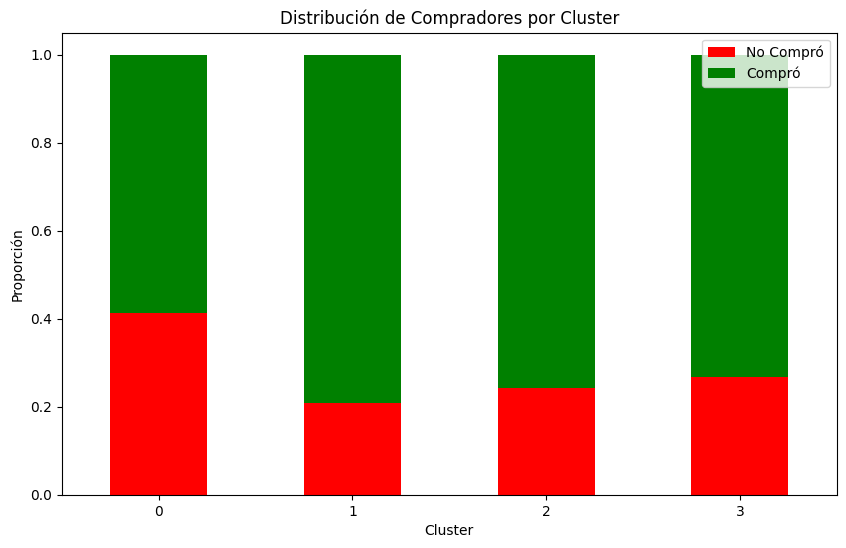

In [40]:
import matplotlib.pyplot as plt

# Crear un gráfico de barras para ver la proporción de compradores en cada cluster
cluster_comprador.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(10, 6))
plt.title('Distribución de Compradores por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proporción')
plt.xticks(rotation=0)
plt.legend(['No Compró', 'Compró'])
plt.show()


# 📊 Conclusiones a partir de la relación entre los Clusters y la variable `comprador`

A continuación, interpretamos los resultados en función de la proporción de compradores (`comprador = 1`) y no compradores (`comprador = 0`) en cada cluster:

## 📍 Cluster 0 (🟣 Púrpura - Baja apertura y bajo CTR)
- **Proporción de compradores:** 58.6%  
- **Proporción de no compradores:** 41.4%  

### 📌 Conclusión:
A pesar de que estos usuarios tienen **baja interacción** con los correos, sorprendentemente, **más de la mitad terminan comprando** (58.6%).  
Esto indica que, aunque no interactúan mucho con los mails, **igual convierten**.  

### 🎯 Acción recomendada:
✅ Enviarles **menos correos** pero con contenido más específico y persuasivo.  
✅ Probar **otros canales de comunicación**, como **SMS** o **notificaciones push**.  

---

## 📍 Cluster 1 (🔵 Azul - Alta apertura pero bajo CTR)
- **Proporción de compradores:** 79.1% 🚀  
- **Proporción de no compradores:** 20.9%  

### 📌 Conclusión:
Este grupo **abre muchos correos**, pero no hace tantos clics. Sin embargo, **es el que más convierte** (79.1%).  
Esto sugiere que, aunque **no interactúan con los enlaces de los mails, de alguna otra manera terminan comprando**.  

### 🎯 Acción recomendada:
✅ **Optimizar el contenido** de los correos para mejorar el **CTR** y aprovechar su **alta apertura**.  
✅ Enviar **ofertas exclusivas** para mejorar aún más la conversión.  

---

## 📍 Cluster 2 (🟢 Verde - Alta apertura y alto CTR)
- **Proporción de compradores:** 75.8%  
- **Proporción de no compradores:** 24.2%  

### 📌 Conclusión:
Este es el grupo de usuarios **más altamente comprometidos** (abren y hacen clic en los mails con frecuencia).  
El **75.8% termina comprando**, lo que confirma que **este segmento es el más valioso** y reacciona bien a los correos.  

### 🎯 Acción recomendada:
✅ Seguir enviando **campañas personalizadas** a este grupo.  
✅ Implementar un **programa de fidelización** o descuentos exclusivos para retenerlos.  

---

## 📍 Cluster 3 (🟡 Amarillo - Mediana apertura y CTR variable)
- **Proporción de compradores:** 73.1%  
- **Proporción de no compradores:** 26.8%  

### 📌 Conclusión:
Este grupo tiene una **interacción media** con los correos y un **buen porcentaje de conversión** (73.1%).  
Puede tratarse de un **segmento en proceso de fidelización**.  

### 🎯 Acción recomendada:
✅ Seguir **segmentando** para entender qué motiva su comportamiento.  
✅ Probar **diferentes tipos de contenido** y **frecuencias de envío**.  
